## Importing required modules

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, pairwise_distances

## Experiments ran with Random Forest

####This notebook includes the following experiments conducted using various parameters for the Random Forest algorithm:

####1. A comprehensive analysis was performed with various max_depth values, and an elbow curve was plotted to evaluate the model's performance.
####2. Implementation of grid search cross-validation to optimize the Random Forest hyperparameters, which include max_depth, min_samples_split, and min_samples_leaf.

In [ ]:
def save_test_predictions_in_kaggle_format(array, experiment=None, save=False):
    # Create a DataFrame with "Id" and "Predicted" columns
    df = pd.DataFrame({'Id': range(len(array)), 'Predicted': array})

    if save:
        assert experiment != None
        # Save the DataFrame to a CSV file
        df.to_csv(f"{experiment}-submission.csv", index=False)

    return df

## Loading the cleaned dataset

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

train_df = pd.read_csv("/content/drive/MyDrive/train_clean.csv")
X_test = pd.read_csv("/content/drive/MyDrive/test_clean.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Run the below cell if you want to load the dataset locally

In [ ]:
datasets_path = "../../datasets/final"
train_path = f"{datasets_path}/train_clean.csv"
test_path = f"{datasets_path}/test_clean.csv"

#load dataframe
train_df = pd.read_csv(train_path)
X_test = pd.read_csv(test_path)

In [ ]:
y = train_df['monthly_rent']
X = train_df.drop(columns=['monthly_rent'])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.head()

,rent_approval_date,flat_type,floor_area_sqm,lease_commence_date,latitude,longitude,distance_to_nearest_existing_mrt,distance_to_nearest_planned_mrt,distance_to_nearest_school,distance_to_nearest_mall,...,town_pasir ris,town_punggol,town_queenstown,town_sembawang,town_sengkang,town_serangoon,town_tampines,town_toa payoh,town_woodlands,town_yishun
49578,0.866081,0.50,0.397790,0.603774,1.308722,103.796751,0.147207,0.326400,0.507243,0.097611,...,False,False,True,False,False,False,False,False,False,False
50763,0.767289,0.75,0.563536,0.339623,1.346522,103.734843,0.201964,0.068745,0.346423,0.682251,...,False,False,False,False,False,False,False,False,False,False
24147,0.933041,0.75,0.491713,0.490566,1.367566,103.951903,0.260956,0.060712,0.028869,0.249039,...,True,False,False,False,False,False,False,False,False,False
13290,0.599341,0.25,0.215470,0.396226,1.363576,103.745977,0.336514,0.071959,0.145460,0.647535,...,False,False,False,False,False,False,False,False,False,False
17890,0.198683,0.75,0.558011,0.547170,1.346176,103.757834,0.385762,0.162398,0.062420,0.461309,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
y_train.head()

49578    4000
50763    4000
24147    3550
13290    2750
17890    2000
Name: monthly_rent, dtype: int64

In [ ]:
len(X_test)

30000

##### During the initial analysis, I utilized the elbow curve method to determine the optimal maximum depth for the tree-based model.Consequently, I did further analysis by utilizing other techniques such as grid search to effectively evaluate the model's performance and fine-tune the parameters.

## Initial Model Fitting and Evaluation with Random Forest (Max Depth: 10)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Create the Random Forest Regressor with max_depth set to 10
rf_regressor = RandomForestRegressor(max_depth=10)

# Fitting the model
rf_regressor.fit(X_train, y_train)

# Predicting on the test set
y_pred_rf = rf_regressor.predict(X_val)

# Calculating the Mean Squared Error
mse_rf = mean_squared_error(y_val, y_pred_rf)

# Printing the Mean Squared Error
print(f"Mean Squared Error for 10 (First Try - Random Forest): {mse_rf**0.5}")

Mean Squared Error for 10 (First Try - Random Forest): 486.5000496137789


## 1. Trying for different values of Max Depth and plotting the elbow curve

100%|██████████| 19/19 [20:26<00:00, 64.57s/it]


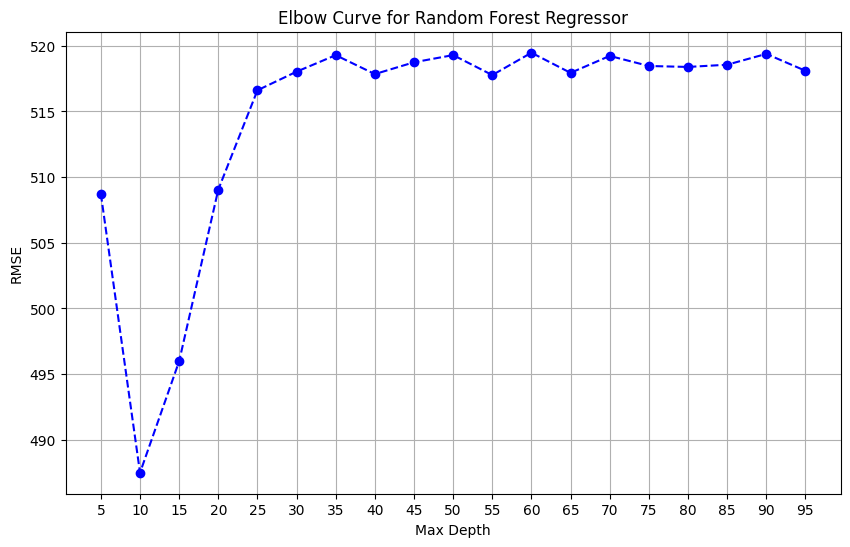

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

start = 5
end = 100
step = 5
depth_values = list(range(start, end, step))

rms_values_dt = []

for depth in tqdm(depth_values):
    model = RandomForestRegressor(max_depth=depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Evaluate the model using Mean Squared Error
    mse = mean_squared_error(y_val, y_pred)
    rms_values_dt.append(mse ** 0.5)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(depth_values, rms_values_dt, marker='o', linestyle='--', color='b')
plt.title('Elbow Curve for Random Forest Regressor')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.xticks(depth_values)
plt.grid()
plt.show()

In [ ]:
!pip install -U dask-cudf
!pip install -U dask-cuda


##2. Grid Search CV Implementation for Random Forest Hyperparameter Tuning

#### Hyperparameters: (n_estimators, max_depth, min_samples_split, min_samples_leaf)

In [ ]:
import numpy as np
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")

# Define the parameters for the grid search
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': list(range(7, 12, 1)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create a Random Forest Regressor
rf = RandomForestRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=3)

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Get the best estimator (model)
best_rf = grid_search.best_estimator_

# Make predictions on the validation data
y_pred = best_rf.predict(X_val)

# Calculate the root mean squared error (RMSE)
rmse = mean_squared_error(y_val, y_pred, squared=False)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV 1/5] END max_depth=7, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-245717.278 total time=  20.9s
[CV 2/5] END max_depth=7, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-250799.765 total time=  22.6s
[CV 3/5] END max_depth=7, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-246041.803 total time=  22.4s
[CV 4/5] END max_depth=7, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-245381.045 total time=  23.8s
[CV 5/5] END max_depth=7, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-257192.688 total time=  21.5s
[CV 1/5] END max_depth=7, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=-245834.633 total time=  33.5s
[CV 2/5] END max_depth=7, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=-250953.562 total time=  32.3s
[CV 3/5] END max_depth=7, min_samples_leaf=1, min_samples_split=2, n_estimat

In [ ]:
# Print the best hyperparameters and RMSE
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"RMSE: {rmse}")

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
RMSE: 486.3267272337927


## Making predictions for the Random Forest Regressor

In [ ]:
y_pred_test = best_rf.predict(X_test)

save_test_predictions_in_kaggle_format(y_pred_test, "Random Forest Regressor", True)

,Id,Predicted
0,0,3340.093623
1,1,2749.198776
2,2,3526.018492
3,3,1945.973680
4,4,2697.324309
...,...,...
29995,29995,3071.040796
29996,29996,2938.753299
29997,29997,2687.489128
29998,29998,3332.146438
